# Cusp Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import sidetable
import utils
import StressTools as tools

## Clean up cusp data file

In [2]:
raw = pd.read_csv('cuspData/CuspDataFromKyleMohr.csv')

# Remove extra measurements beyond 2
raw = raw.groupby('Cusp_ID').head(2)

# Remove items that only have 1 angle measurement
freq = raw.stb.freq(['Cusp_ID'])
singles = freq.loc[freq['Count'] < 2]
mask = ~raw.Cusp_ID.isin(singles.Cusp_ID)
cusps = raw[mask].copy()

### Convert latitudes and longitudes

In [3]:
cusps['lon'] = (360 - cusps['Long_dd']) % 360
cusps['lat'] = 90 - cusps['Lat_dd']

## Split data into left and right groups

In [4]:
left_cusps = cusps.iloc[::2]
right_cusps = cusps.iloc[1::2]

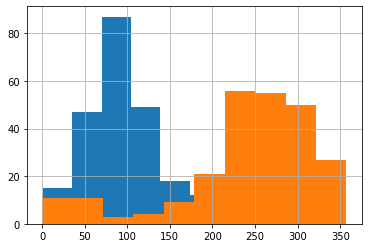

In [5]:
left_cusps.CompassA.hist()
right_cusps.CompassA.hist()

## Get stress field for cusps

In [6]:
interior = interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

left_stress = tools.get_simon_stress_field(interior, left_coords, 0, 0.01, 0, 0)
right_stress = tools.get_simon_stress_field(interior, right_coords, 0, 0.01, 0, 0)

## Match Angles to stresses

In [86]:
from io import BytesIO
import base64

def figureToInlineImage(figure):
    file = BytesIO()
    figure.savefig(file, format='png')
    file.seek(0)
    
    png_data = base64.b64encode(file.getvalue()).decode()
    image_str = f'<img width="200" height="100" src="data:image/png;base64,{png_data}" />'
    
    return image_str

def match_angles(points, stresses, name, show_plots=True):
    results = []
    
    for point in points.itertuples():
        stress_data = stresses.loc[(stresses.lon == point.lon) & (stresses.lat == point.lat)]
        
        sorted_stress = stress_data.copy().sort_values('heading')
        angle = point.CompassA if point.CompassA >= 180 else (180 + point.CompassA) % 360

        spline = InterpolatedUnivariateSpline(sorted_stress.heading, sorted_stress.stress)
        slopes = spline.derivative()
        
        matched_stress = spline(angle)
        slope = slopes(angle)
        is_increasing = slope > 0
        max_stress = stress_data.stress.max()
        min_stress = stress_data.stress.min()

        image = ''
        if show_plots:
            fig, ax = plt.subplots(figsize=(4,2))
            
            ax.title.set_text(f'{name} - lat: {point.lat}, lon: {point.lon}')
            ax.vlines(angle, ymin=min_stress, ymax=max_stress, colors=['red'], linestyles='dashed')
            ax.hlines(matched_stress, xmin=175, xmax=360, colors=['red'], linestyles='dashed')

            spx = np.linspace(180, 360, 360)
            ax.plot(spx, spline(spx))
            image = figureToInlineImage(fig)
            plt.show()

        
        results.append(dict(lat=point.lat,
                            lon=point.lon,
                            Id=point.Id,
                            cycloid_number=point.Cycloid_Nu,
                            cusp_id=point.Cusp_ID,
                            orientation_original=point.CompassA,
                            orientation_translated=angle,
                            stress=matched_stress, 
                            max_stress=max_stress, 
                            slope=slope,
                            is_increasing=is_increasing,
                            stress_plot=image))
        
    return pd.DataFrame(results)

In [89]:
left_points = left_cusps #.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 13]


left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=False)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=False)
left_matched['cusp_direction'] = 'left'
right_matched['cusp_direction'] = 'right'

## Output Unified Dataset

In [90]:
all_matches = pd.concat([left_matched, right_matched])
all_matches.to_csv('./output/leftRight/interpolatedStress.csv.gz', compression='gzip', index=False)

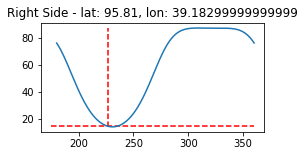

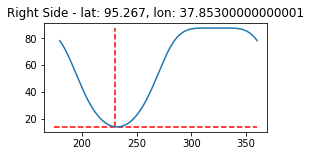

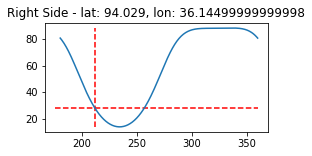

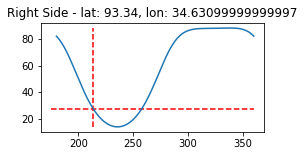

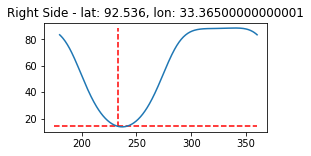

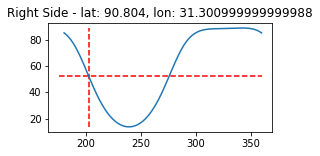

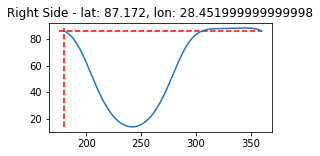

In [87]:
# left_points = left_cusps.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps.loc[right_cusps.Cycloid_Nu == 14]


# left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=True)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=True)
# left_matched['cusp_direction'] = 'left'
# right_matched['cusp_direction'] = 'right'

,cycloid_number,Id,stress,max_stress,orientation_original,orientation_translated,stress_plot
0,14,1,14.430622388199103,87.700573,227.121096,227.121096,
1,14,2,14.11951310555491,87.782540,230.194429,230.194429,
2,14,3,28.010837705825754,88.216836,211.607502,211.607502,
3,14,4,27.306400467408206,88.415325,213.690067,213.690067,
4,14,5,14.172452300509871,88.610706,233.130102,233.130102,
5,14,6,52.050867084390575,88.860376,202.520566,202.520566,
6,14,7,86.27613560528114,88.522857,180.000000,180.000000,

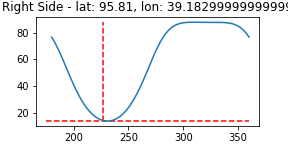
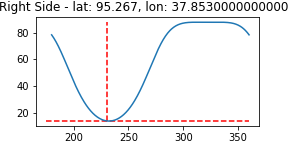
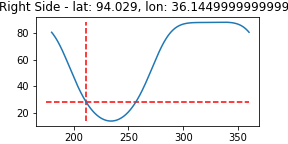
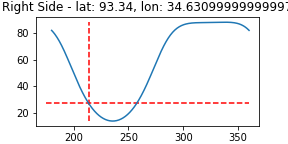
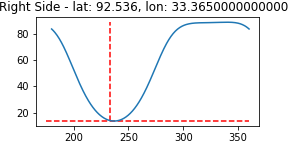
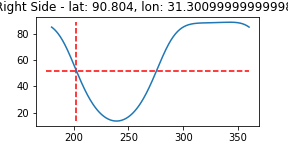
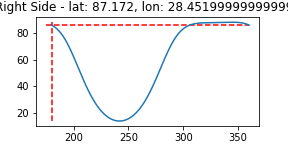

In [88]:
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)


HTML(right_matched[['cycloid_number', 'Id', 'stress', 'max_stress', 'orientation_original', 'orientation_translated', 'stress_plot']].to_html(escape=False))
# left_matched


In [81]:
all_matches.loc[(all_matches.cycloid_number == 14)]

,lat,lon,Id,cycloid_number,cusp_id,orientation_original,orientation_translated,stress,max_stress,slope,is_increasing,stress_plot,cusp_direction
45,95.810,39.183,1,14,48,227.121096,227.121096,14.430622388199103,87.700573,-0.19858858531198564,False,NaN,right
46,95.267,37.853,2,14,49,230.194429,230.194429,14.11951310555491,87.782540,-0.11034300555870714,False,NaN,right
47,94.029,36.145,3,14,50,211.607502,211.607502,28.010837705825754,88.216836,-1.3095401452033517,False,NaN,right
48,93.340,34.631,4,14,51,213.690067,213.690067,27.306400467408206,88.415325,-1.2777041946308936,False,NaN,right
49,92.536,33.365,5,14,52,233.130102,233.130102,14.172452300509871,88.610706,-0.20546290212663848,False,NaN,right
50,90.804,31.301,6,14,53,202.520566,202.520566,52.050867084390575,88.860376,-1.9932114341337386,False,NaN,right
51,87.172,28.452,7,14,54,180.000000,0.000000,3797.5804826021194,88.522857,-66.12406495557298,False,NaN,right
